In [55]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.backends.backend_pdf import PdfPages
from scipy.cluster.vq import vq, kmeans, whiten
from collections import Counter
import colorsys
from scipy.stats import beta
import matplotlib.gridspec as gridspec
import random
import os
from scipy.interpolate import pchip
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy.ma as ma
from scipy.stats import entropy
from collections import OrderedDict    # For recording the model specification 
import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations
import pylogit as pl                   # For MNL model estimation and
import warnings
warnings.filterwarnings("ignore")

We aim to analyze the energy consumption pattern while  also explore possible factors that will influece the energy consumption pattern. The data used in this project is from Pecan St Dataport and Meteostat API.

1. Read Data. 

In [56]:
df_meta = pd.read_csv('pecan/15minute_data_austin/metadata.csv')
df_data = pd.read_csv('pecan/15minute_data_austin/15minute_data_austin.csv')

In [57]:
df_meta.head(10)

,dataid,active_record,building_type,city,state,egauge_1min_min_time,egauge_1min_max_time,egauge_1min_data_availability,egauge_1s_min_time,egauge_1s_max_time,...,program_baseline,program_energy_internet_demo,program_lg_appliance,program_verizon,program_ccet_group,program_civita_group,program_shines,energy_storage_system,energy_storage_system_l1,energy_storage_system_l2
0,The unique identifier for the home. To be more...,this field will show yes if this participant i...,This field will read Single-Family Home if thi...,participant's city,participant's state,"If eGauge electricity data is present, this fi...","If eGauge electricity data is present, this fi...",This field shows how much one minute data is ...,If eGauge electricity data is present in one s...,If eGauge electricity data is present in one s...,...,This field will show 'yes' if this participant...,This field will show 'yes' if this participant...,This field will show 'yes' if this participant...,This field will show 'yes' if this participant...,This field will show one of the following grou...,This field will show one of the following grou...,This field will show 'yes' if this participant...,eGauge data present for a battery or other typ...,eGauge data present for leg 1 of a battery or ...,eGauge data present for leg 2 of a battery or ...
1,2836,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2743,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5323,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8560,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3313,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5052,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3936,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1622,NaN,Town Home,Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1114,NaN,Single-Family Home 001 (Master),Austin,Texas,NaN,NaN,NaN,NaN,NaN,...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
bedroom = ['bedroom1', 'bedroom2','bedroom3', 'bedroom4', 'bedroom5']
bathroom = ['bathroom1', 'bathroom2']
air = ['air1', 'air2', 'air3']
car = ['car1', 'car2']
diningroom = ['diningroom1','diningroom2']
furnace = ['furnace1', 'furnace2'] 
garage = ['garage1', 'garage2']
kitchen = ['kitchen1','kitchen2']
kitchenapp = ['kitchenapp1', 'kitchenapp2']
lights_plugs = ['lights_plugs1','lights_plugs2', 'lights_plugs3', 'lights_plugs4', 'lights_plugs5','lights_plugs6']
livingroom = ['livingroom1', 'livingroom2']
outsidelights_plugs = ['outsidelights_plugs1', 'outsidelights_plugs2'] 
oven = ['oven1', 'oven2']
pool = ['pool1', 'pool2']
refrigerator = ['refrigerator1', 'refrigerator2'] 
solar = ['solar', 'solar2']
waterheater = ['waterheater1', 'waterheater2']
other = ['airwindowunit1','aquarium1', 
        'battery1', 'circpump1', 'clotheswasher1', 'clotheswasher_dryg1', 
        'dishwasher1', 'disposal1', 'drye1', 'dryg1', 'freezer1',
        'grid', 'housefan1', 'icemaker1', 'jacuzzi1', 'microwave1', 
        'office1','poollight1', 'poolpump1', 'pump1', 'range1',
        'security1', 'sewerpump1', 'shed1','sprinkler1', 'sumppump1', 
        'utilityroom1','venthood1', 'wellpump1', 'winecooler1']
appliance_multi= [bedroom,bathroom,air,car,diningroom,
furnace,garage,kitchen,kitchenapp,lights_plugs,livingroom,
outsidelights_plugs,oven,pool,refrigerator,solar,waterheater]

df = df_data[other]
for appliance in appliance_multi:
    appliance_name = appliance[0]
    df[appliance_name] = np.sum(df_data[appliance],axis=1)

In [59]:
df_des = df.describe().transpose()
df_des = df_des[(df_des['count']>0)&(df_des['max']>0)]
df_use = df[df_des.index]
for col in df_use.columns:
    a = df_use[col].quantile(0.99)
    b = df_use[col].quantile(0.01)
    c = df_use[col]
    c[(c>a)|(c<=b)]=np.nan
    c.fillna(0,inplace=True)
df_use.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
airwindowunit1,873286.0,0.001091,0.015932,0.000,0.000,0.000,0.00000,0.779
clotheswasher1,873286.0,0.005437,0.020398,0.000,0.000,0.000,0.00100,0.148
dishwasher1,873286.0,0.006243,0.037932,-0.001,0.000,0.001,0.00100,0.580
disposal1,873286.0,0.000269,0.001205,0.000,0.000,0.000,0.00000,0.007
drye1,873286.0,0.015457,0.150414,-0.004,0.000,0.000,0.00200,2.269
dryg1,873286.0,0.002062,0.020398,0.000,0.000,0.000,0.00000,0.289
freezer1,873286.0,0.000085,0.000419,0.000,0.000,0.000,0.00000,0.003
grid,873286.0,0.821082,1.464538,-3.433,0.266,0.583,1.39400,5.689
microwave1,873286.0,0.005472,0.017215,0.000,0.002,0.003,0.00400,0.203
office1,873286.0,0.007445,0.031877,0.000,0.000,0.000,0.00000,0.421


In [60]:
df_use['data_id'] = df_data['dataid']
df_use['local_15min'] = pd.to_datetime(df_data['local_15min'],utc=True)
df_use['year'] = df_use['local_15min'].dt.year
df_use['month'] = df_use['local_15min'].dt.month
df_use['day'] = df_use['local_15min'].dt.day
df_use['hour'] = df_use['local_15min'].dt.hour
df_use['min'] = df_use['local_15min'].dt.minute

In [61]:
cols = ['airwindowunit1', 'clotheswasher1', 'dishwasher1',
       'disposal1', 'drye1', 'dryg1', 'freezer1', 'grid', 'microwave1',
       'office1', 'range1', 'sprinkler1', 'utilityroom1', 'venthood1',
       'winecooler1', 'bedroom1', 'bathroom1', 'air1', 'car1', 'diningroom1',
       'furnace1', 'garage1', 'kitchen1', 'kitchenapp1', 'lights_plugs1',
       'livingroom1', 'outsidelights_plugs1', 'oven1', 'refrigerator1',
       'solar', 'waterheater1']

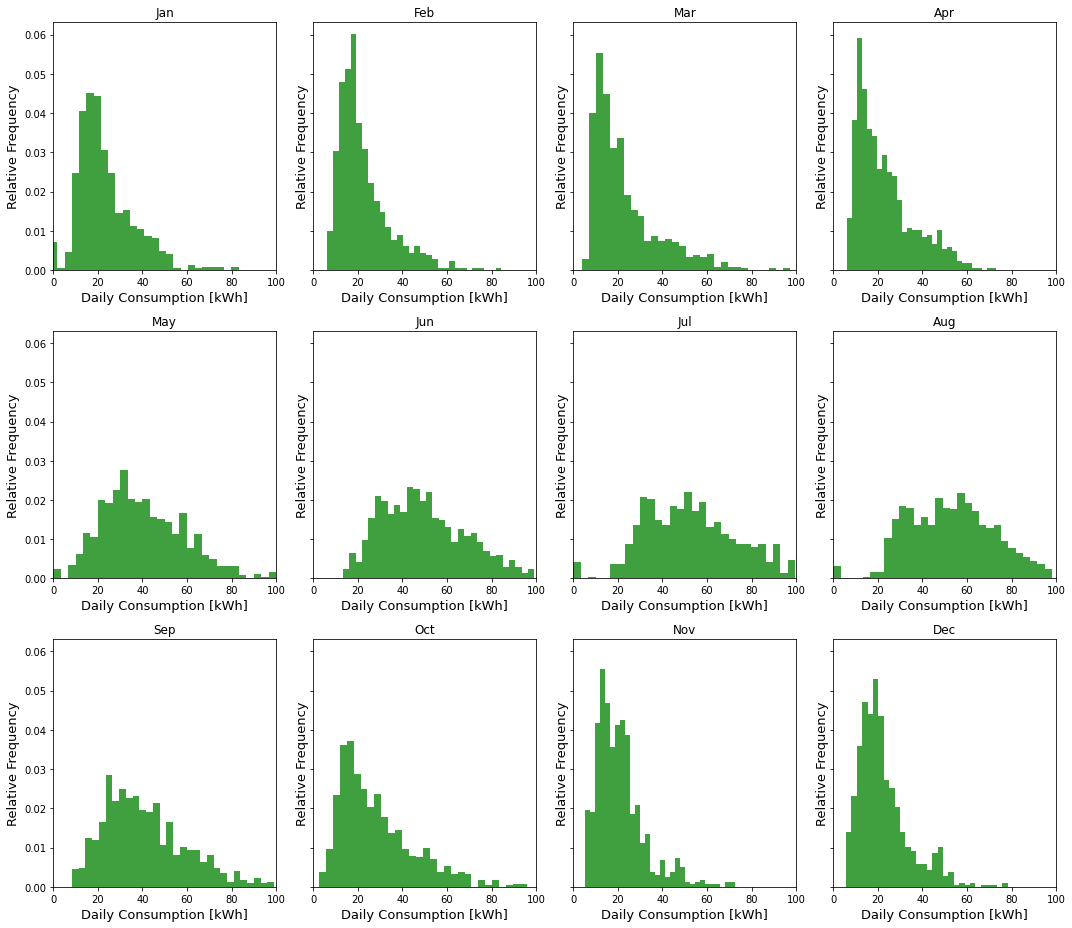

In [62]:
def getValue(df,month):
    df_mon = df[df['month']==month]
    table = pd.pivot_table(df_mon, values='sum_energy', index=['dataid','year','month','day'],columns='hour',aggfunc=np.sum)
    table = table.dropna(axis=0,how='any')
    consumption = np.sum(table,axis=1)
    consumption = consumption.values*0.25
    consumption = consumption[(consumption<=100)]
    return consumption

def getMeta(df,state):
    df = df[(df['building_type']=='Single-Family Home 001 (Master)')&(df['state']==state)]
    #df = df[(df['building_type']=='Apartment')&(df['state']==state)]
    return list(df['dataid'].values.astype(int))

def preFile(df,dataid,year):
    process_col = ['grid','solar','solar2']
    df['local_15min'] = pd.to_datetime(df['local_15min'],utc=True)
    df['year'] = df['local_15min'].dt.year
    df['month'] = df['local_15min'].dt.month
    df['day'] = df['local_15min'].dt.day
    df['hour'] = df['local_15min'].dt.hour
    df['sum_energy'] = np.sum(df[process_col],axis=1)
    return df

at_df = pd.read_csv('pecan/15minute_data_austin/15minute_data_austin.csv')
df_meta = pd.read_csv('pecan/15minute_data_california/metadata.csv')
dataid_at = getMeta(df_meta,'Texas')
at_df_pre = preFile(at_df,dataid_at,2018)
monnum = ['01','02','03','04','05','06','07','08','09','10','11','12']
monname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monid = range(12)
fig, axs = plt.subplots(nrows=3, ncols=4, sharey=True, figsize=(15,13))
for month,num,id in zip(monname,monnum,monid):
    # the histogram of the data, to ensure anonymity, the random account identifiers will continue to change for each customer.
    i = int(id/4); j = int(id%4)
    axs[i,j].hist(getValue(at_df_pre,id+1), 30, density=True, facecolor='g', alpha=0.75)
    axs[i,j].set_xlim(0,100)
    #axs[i,j].set_xticks(fontsize = 15)
    #axs[i,j].set_yticks(fontsize = 15)
    axs[i,j].set_xlabel('Daily Consumption [kWh]',fontsize = 13)
    axs[i,j].set_ylabel('Relative Frequency',fontsize = 13)
    axs[i,j].set_title(month)
plt.tight_layout()

It is obvious that the temperature is relatively high during Jul. - Oct. 
and relatively low during other monthes. Accordingly, the energy consumption
distribution is more flat during Jul. - Oct., i.e., more people intend to use
more energy, while the energy consumption tends to have a peak during other monthes.

2. Data visualization

2.0 Choice

We have binary choices in our model. '2' means that the user chooses to use the appliance while '1' menas that the user chooses not using the appliance.

In [63]:
def roll_choice(df,user_id,appliance_id):
    table = pd.pivot_table(df[(df['data_id']==user_id)], values=appliance_id, index=['data_id','year','month','day'],aggfunc=np.sum) 
    table['choice'] = table[appliance_id]
    table['choice'][table[appliance_id]>0] = 2
    table['choice'][table[appliance_id]<=0] = 1
    choice_val = table['choice'].values
    return choice_val

In [64]:
choice_val = roll_choice(df_use,661,'clotheswasher1')

2.1 Entropy

For each appliance and each house, we extract the appliance energy consumption. We convert these counts into a cumulative probability density function (CDF). Our intuition is that the shapes of the CDF curves present useful information about how each house uses a specific appliance. For example, sharp jumps in a CDF mean that the residents use their appliance around specific value and would be less willing for shifting their usage. In contrast, the houses with smoother profiles would be more open to alter their original appliance usage schedule, as their usage times are more uniformly distributed across a day. 

Next, we assign values to different CDF curve shapes, i.e., a function that translates a CDF curve into a numerical value. To achieve this, we use a well-known concept: (Shannon) entropy. Entropy is a measure of unpredictability of information content. In our case, when the appliance energy accumulate around certain intervals, the CDF curve has sharp jumps and becomes more predictable. Thus, the amount of information CDF curve carries is low and this translates into low entropy. In contrast, a smoother CDF means that the appliance energy consumption is less predictable and thus it has a high entropy value. 

In [65]:
def epdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, counts / cusum[-1]    

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    
    fig, axs = plt.subplots(figsize=(15,3))
    plt.plot(x, y, drawstyle='steps-post',color='g')
    plt.plot(x, y , 'o--', markersize=10, color='grey', alpha=0.3)
    plt.grid(axis='x', color='0.95')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Appliance Energy Consumption [kWh]',fontsize=20)
    plt.ylabel('Cumulated Probability Function',fontsize=20)
    plt.title('CDF for Appliance Entropy',fontsize=20)
    plt.tight_layout()

In [66]:
def comp_entropy(df_entropy,entropy_type,appliance_id):
    if entropy_type == 'time':
        df_entropy = df_entropy[(df_entropy[appliance_id]>0)]
        table = pd.pivot_table(df_entropy, values='hour', index=['data_id','year','month','day'],aggfunc=np.min)
        x, y = epdf(table['hour'])
        etpy = entropy(y, base=2)
    if entropy_type == 'amount':
        table = pd.pivot_table(df_entropy, values=appliance_id, index=['data_id','year','month','day'],aggfunc=np.sum)
        x, y = epdf(table[appliance_id])
        etpy = entropy(y, base=2)
    return etpy

In [67]:
def roll_entropy(df,user_id,appliance_id,n_days):
    entropy_val = []
    table = pd.pivot_table(df[(df['data_id']==user_id)], values=appliance_id, index=['data_id','year','month','day'],aggfunc=np.sum)
    for i in range(n_days,len(table)):
        table_en = table[i-n_days:i]
        x, y = epdf(table_en[appliance_id])
        etpy = entropy(np.array(y), base=2)
        entropy_val.append(etpy)    
    return entropy_val

In [68]:
entropy_val = roll_entropy(df_use,661,'clotheswasher1',7)

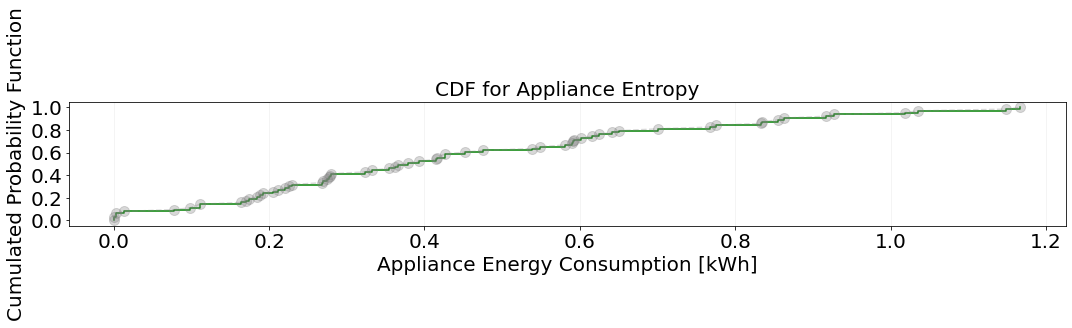

In [69]:
df_661 = df_use[(df_use['data_id']==661)&(df_use['hour']>=17)&(df_use['hour']<=20)&(df_use['clotheswasher1']>0)]
table = pd.pivot_table(df_661, values='clotheswasher1', index=['data_id','year','month','day'],aggfunc=np.sum)
plot_ecdf(table['clotheswasher1'])

2.2 Energy consumption

The hourly energy consumption of user during whole year for certain appliance.

In [70]:
def roll_energy(df,user_id,appliance_id,n_days):
    entropy_val = []
    table = pd.pivot_table(df[(df['data_id']==user_id)], values=appliance_id, index=['data_id','year','month','day'],aggfunc=np.sum)
    for i in range(n_days,len(table)):
        table_en = table[i-n_days:i]
        entropy_val.append(np.mean(table_en)[0])
    return entropy_val

In [71]:
energy_val = roll_energy(df_use,661,'clotheswasher1',7)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

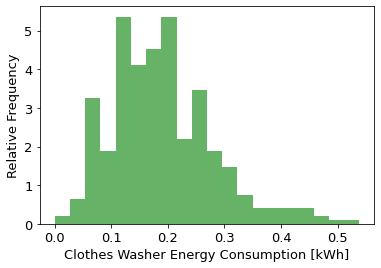

In [110]:
b = plt.hist(energy_val, 20, density=True, facecolor='g', alpha=0.6)
plt.xlabel('Clothes Washer Energy Consumption [kWh]', fontsize=13)
plt.ylabel('Relative Frequency', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

2.3 Temperature

In [73]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [74]:
from datetime import datetime
from meteostat import Point, Hourly, Daily
start = datetime(2018, 1, 1)
end = datetime(2019, 1, 1)
location = Point(30.2666, -97.7333, 70)
data = Daily(location, start, end)
at_df_api = data.fetch()
table = at_df_api

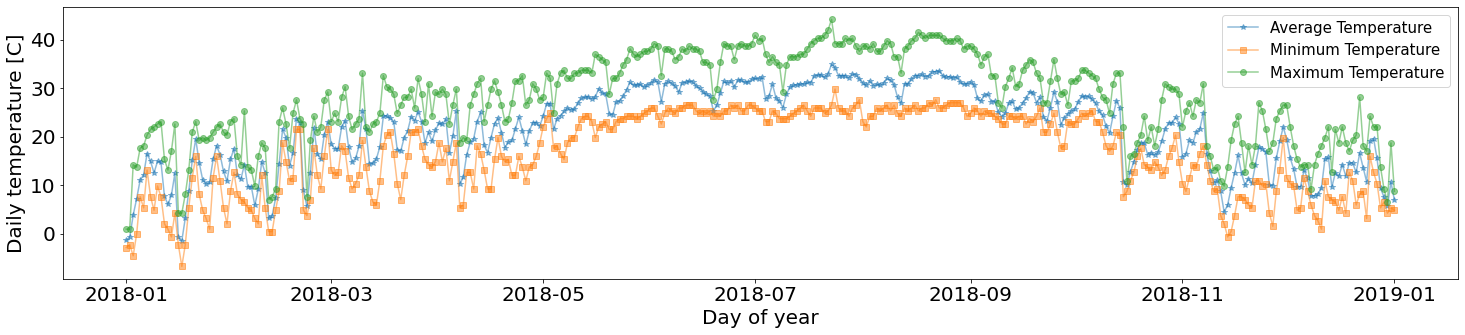

In [75]:
data = Daily(location, start, end)
data = data.fetch()
# data.plot(y=['tavg', 'tmin', 'tmax'])
fig, axs = plt.subplots(figsize=(25,5))
plt.plot(data['tavg'],marker ='*', label='Average Temperature',alpha=0.5)
plt.plot(data['tmin'],marker ='s',label='Minimum Temperature',alpha=0.5)
plt.plot(data['tmax'],marker ='o',label='Maximum Temperature',alpha=0.5)
plt.ylabel('Daily temperature [C]',fontsize=20)
plt.xlabel('Day of year',fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=15)
plt.show()

In [76]:
temperature = table['tavg'][7:]
temperature

time
2018-01-08    14.9
2018-01-09    12.5
2018-01-10    14.9
2018-01-11    14.7
2018-01-12     7.7
              ... 
2018-12-28     9.4
2018-12-29     7.5
2018-12-30     5.7
2018-12-31    10.6
2019-01-01     6.9
Freq: D, Name: tavg, Length: 359, dtype: float64

2.4 Energy price

* Tier 1: 0 – 500 kWh	 	2.801¢
* Tier 2: 501 – 1,000 kWh	 	5.832¢
* Tier 3: 1,000 – 1,500 kWh	 	7.814¢
* Tier 4: 1,501 – 2,500 kWh	 	9.314¢
* Tier 5: > 2,500 kWh	 	10.814¢

In [77]:
def roll_price(df_use,user_id):
    table = pd.pivot_table(df_use[(df_use['data_id']==user_id)], values = 'grid', index=['data_id','year','month','day'],aggfunc=np.sum)
    table = table.reset_index()
    price_list = []
    for i in range(len(table)):
        month = table['month'][i]
        day = table['day'][i]
        table_month = table[(table['month']==month)&(table['day']<=day)]
        accum = np.sum(table_month['grid'])
        if accum <= 500:
            price = 0.02801
        if accum > 500 and accum <= 1000:
            price = 0.05832
        if accum > 1000 and accum <= 1500:
            price = 0.07814
        if accum > 1500 and accum <= 2500:
            price = 0.09314
        if accum > 2500:
            price = 0.10814
        price = price
        price_list.append(price)
    return price_list

In [78]:
def roll_temperature(df_use,user_id):
    table = pd.pivot_table(df_use[(df_use['data_id']==user_id)], values = 'grid', index=['data_id','year','month','day'],aggfunc=np.sum)
    table = table.reset_index()
    temperature_list = []
    for i in range(len(table)):
        year = table['year'][i]
        month = table['month'][i]
        day = table['day'][i]
        start = datetime(year, month, day)
        end = datetime(year, month, day)
        location = Point(30.2666, -97.7333, 70)
        data = Daily(location, start, end)
        at_df_api = data.fetch()
        temperature_list.append(at_df_api['tavg'][0])
    return temperature_list

In [79]:
df_use['data_id'].unique()

array([ 661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767,
       5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019,
       9160, 9922, 9278])

In [80]:
user_id = 2335
appliance_id = 'clotheswasher1'
temperature_val = roll_temperature(df_use,user_id)[7:]
price_val = roll_price(df_use,user_id)[7:]
energy_val = roll_energy(df_use,user_id,appliance_id,7)
entropy_val = roll_entropy(df_use,user_id,appliance_id,7)
choice_val = roll_choice(df_use,user_id,appliance_id)[7:]

In [81]:
table = pd.DataFrame(data={'energy': energy_val, 'entropy': entropy_val, 'price':price_val, 'choice':choice_val, 'temperature':temperature_val}) 
table

,energy,entropy,price,choice,temperature
0,0.180286,2.521641,0.02801,2.0,14.9
1,0.181714,2.807355,0.02801,2.0,12.5
2,0.181857,2.807355,0.02801,2.0,14.9
3,0.182143,2.521641,0.02801,2.0,14.7
4,0.117857,2.521641,0.02801,2.0,7.7
...,...,...,...,...,...
349,0.171286,1.148835,0.05832,1.0,9.4
350,0.047286,0.591673,0.05832,1.0,7.5
351,0.047286,0.591673,0.07814,2.0,5.7
352,0.087571,1.148835,0.07814,2.0,10.6


3. Build the model 

There are two issues that need to be solved.

1. Which appliance is more important to the user?

- Discrete Choice Model to estimate the value of energy.
    * Build the binary choice model. 
        - $U_{yes} = \beta_{0}+\beta_{energy} x_{energy} + \beta_{price} x_{price} + \beta_{entropy} x_{entropy} + \beta_{temperature} x_{temperature}$
        - $U_{no} = 0$
    * Willingness to pay. coefficient of energy consumption / coefficient of energy price.
        - $WTP = \frac{\beta_{energy}}{\beta_{price}}$
    * Value of energy. willingness to pay * maximum energy consumption  

2. For certain appliance, how the utility increases with the energy conusmption?

- Quadratic Utility Function $U = ax(b-x)$.
    * Rewrite as: $U = a'* (4/b^{2}) * x(b-x)$
    * Maximum energy consumption $b$: maximum energy consumption in past week.  
    * Scaler of the utility $a$: willness to pay for marginal increase in utility.

In [82]:
def comp_weekly_consumption(table,days):
    x = table.rolling(days).mean()
    x = x[days:]
    return x

def comp_weekly_frequency(table,days):
    table[table==0]=np.nan
    print(len(table))
    x = table.rolling(days).count()
    x = x[days:]
    return x

In [83]:
# # compute the maximum energy consumption
# user_id = 661; appliance_id = 'clotheswasher1'; 
# df_user = df_use[(df_use['data_id']==user_id)]
# table = pd.pivot_table(df_user, values=appliance_id, index=['data_id','year','month','day'],aggfunc=np.sum)
# energy_max = np.max(table)
# energy_max

In [84]:
# build the model for user 661 and appliance clotheswasher
table_logit = pd.DataFrame()
# add ind_variables
table_logit["PRICE"] = table["price"]
table_logit["ENTROPY"] = table["entropy"]
table_logit["TEMPERATURE"] = table["temperature"]
table_logit["CONSUMPTION"] = table["energy"]
ind_variables = ["PRICE","ENTROPY","TEMPERATURE","CONSUMPTION"]
# add alt_varying_variables
alt_varying_variables = {}
# add availability_variables
table_logit['APP_Y_AV'] = np.ones(len(table))
table_logit['APP_N_AV'] = np.ones(len(table))
availability_variables = {1: 'APP_N_AV',
                          2: 'APP_Y_AV'}
# determine the columns for: alternative ids, the observation ids and the choice
custom_alt_id = "CHOICEID"
obs_id_column = "RECORDID"
table_logit[obs_id_column] = np.arange(table_logit.shape[0],
                                            dtype=int) + 1
choice_column = "CHOICE"
table_logit["CHOICE"] = table["choice"]
table_logit

,PRICE,ENTROPY,TEMPERATURE,CONSUMPTION,APP_Y_AV,APP_N_AV,RECORDID,CHOICE
0,0.02801,2.521641,14.9,0.180286,1.0,1.0,1,2.0
1,0.02801,2.807355,12.5,0.181714,1.0,1.0,2,2.0
2,0.02801,2.807355,14.9,0.181857,1.0,1.0,3,2.0
3,0.02801,2.521641,14.7,0.182143,1.0,1.0,4,2.0
4,0.02801,2.521641,7.7,0.117857,1.0,1.0,5,2.0
...,...,...,...,...,...,...,...,...
349,0.05832,1.148835,9.4,0.171286,1.0,1.0,350,1.0
350,0.05832,0.591673,7.5,0.047286,1.0,1.0,351,1.0
351,0.07814,0.591673,5.7,0.047286,1.0,1.0,352,2.0
352,0.07814,1.148835,10.6,0.087571,1.0,1.0,353,2.0


In [85]:
# Perform the conversion to long-format
long_data = pl.convert_wide_to_long(table_logit, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)
# Look at the resulting long-format dataframe
long_data.head(10).T

,0,1,2,3,4,5,6,7,8,9
RECORDID,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000
CHOICEID,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
CHOICE,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
PRICE,0.028010,0.028010,0.028010,0.028010,0.028010,0.028010,0.028010,0.028010,0.028010,0.028010
ENTROPY,2.521641,2.521641,2.807355,2.807355,2.807355,2.807355,2.521641,2.521641,2.521641,2.521641
TEMPERATURE,14.900000,14.900000,12.500000,12.500000,14.900000,14.900000,14.700000,14.700000,7.700000,7.700000
CONSUMPTION,0.180286,0.180286,0.181714,0.181714,0.181857,0.181857,0.182143,0.182143,0.117857,0.117857


In [86]:
basic_specification = OrderedDict()
basic_names = OrderedDict()

basic_specification["intercept"] = [2]
basic_names["intercept"] = ['APP_Y']

basic_specification["ENTROPY"] = [2]
basic_names["ENTROPY"] = ['entropy, units:/']

basic_specification["CONSUMPTION"] = [2]
basic_names["CONSUMPTION"] = ['consumption, units:kWh']

basic_specification["PRICE"] = [2]
basic_names["PRICE"] = ['electricity price, units:$/kWh']

basic_specification["TEMPERATURE"] = [2]
basic_names["TEMPERATURE"] = ['temperature, units:C']


In [87]:
# Estimate the binary logit model (
air_travel_logit = pl.create_choice_model(data=long_data,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

# Specify the initial values and method for the optimization.
air_travel_logit.fit_mle(np.zeros(5)) # 4 being the total number of parameters to be estimated


Log-likelihood at zero: -245.3741
Initial Log-likelihood: -245.3741
Estimation Time for Point Estimation: 0.04 seconds.
Final log-likelihood: -216.4100


In [88]:
# Look at the estimation results
air_travel_logit.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                  354
Model:             Multinomial Logit Model   Df Residuals:                      349
Method:                                MLE   Df Model:                            5
Date:                     Mon, 09 May 2022   Pseudo R-squ.:                   0.118
Time:                             15:43:35   Pseudo R-bar-squ.:               0.098
AIC:                               442.820   Log-Likelihood:               -216.410
BIC:                               462.167   LL-Null:                      -245.374
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
APP_Y                              0.3249      0.596      0.545      0.586      -0.844       1.494
entropy, units:/                   0.5904      0.236      2.503      0.012       0.128       1.053
consumption, units:kWh            -2.6819      1.395     -1.922      0.055      -5.416       0.052
electricity price, units:$/kWh   -12.6955      5.100     -2.489      0.013     -22.692      -2.699
temperature, units:C               0.0169      0.016      1.027      0.305      -0.015       0.049
==================================================================================================
"""

In [89]:
def buildTable(user_id,appliance_id,temperature_val):
    price_val = roll_price(df_use,user_id)[7:]
    energy_val = roll_energy(df_use,user_id,appliance_id,7)
    entropy_val = roll_entropy(df_use,user_id,appliance_id,7)
    choice_val = roll_choice(df_use,user_id,appliance_id)[7:]
    table = pd.DataFrame(data={'energy': energy_val, 'entropy': entropy_val, 'price':price_val, 'choice':choice_val, 'temperature':temperature_val}) 
    return table

In [90]:
def solveModel(table):
    # build the model for user 661 and appliance clotheswasher
    table_logit = pd.DataFrame()
    # add ind_variables
    table_logit["PRICE"] = table["price"]
    table_logit["ENTROPY"] = table["entropy"]
    table_logit["TEMPERATURE"] = table["temperature"]
    table_logit["CONSUMPTION"] = table["energy"]
    ind_variables = ["PRICE","ENTROPY","TEMPERATURE","CONSUMPTION"]
    # add alt_varying_variables
    alt_varying_variables = {}
    # add availability_variables
    table_logit['APP_Y_AV'] = np.ones(len(table))
    table_logit['APP_N_AV'] = np.ones(len(table))
    availability_variables = {1: 'APP_N_AV',
                            2: 'APP_Y_AV'}
    # determine the columns for: alternative ids, the observation ids and the choice
    custom_alt_id = "CHOICEID"
    obs_id_column = "RECORDID"
    table_logit[obs_id_column] = np.arange(table_logit.shape[0],
                                                dtype=int) + 1
    choice_column = "CHOICE"
    table_logit["CHOICE"] = table["choice"]
    # Perform the conversion to long-format
    long_data = pl.convert_wide_to_long(table_logit, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)
    basic_specification = OrderedDict()
    basic_names = OrderedDict()

    basic_specification["intercept"] = [2]
    basic_names["intercept"] = ['APP_Y']

    basic_specification["ENTROPY"] = [2]
    basic_names["ENTROPY"] = ['entropy, units:/']

    basic_specification["CONSUMPTION"] = [2]
    basic_names["CONSUMPTION"] = ['consumption, units:kWh']

    basic_specification["PRICE"] = [2]
    basic_names["PRICE"] = ['electricity price, units:$/kWh']

    basic_specification["TEMPERATURE"] = [2]
    basic_names["TEMPERATURE"] = ['temperature, units:C']

    # Estimate the binary logit model (
    air_travel_logit = pl.create_choice_model(data=long_data,
                                            alt_id_col=custom_alt_id,
                                            obs_id_col=obs_id_column,
                                            choice_col=choice_column,
                                            specification=basic_specification,
                                            model_type="MNL",
                                            names=basic_names)

    # Specify the initial values and method for the optimization.
    air_travel_logit.fit_mle(np.zeros(5)) # 4 being the total number of parameters to be estimated
    #air_travel_logit.get_statsmodels_summary()
    wtp = air_travel_logit.summary['parameters'][2]/air_travel_logit.summary['parameters'][3]
    return wtp


In [91]:
appliance_list = ['airwindowunit1', 'clotheswasher1', 'dishwasher1',
       'disposal1', 'drye1', 'dryg1', 'freezer1', 'microwave1',
       'office1', 'range1', 'sprinkler1', 'utilityroom1', 'venthood1',
       'winecooler1', 'bedroom1', 'bathroom1', 'air1', 'car1', 'diningroom1',
       'furnace1', 'garage1', 'kitchen1', 'kitchenapp1', 'lights_plugs1',
       'livingroom1', 'outsidelights_plugs1', 'oven1', 'refrigerator1',
       'solar', 'waterheater1']

In [92]:
id_list = list(df_use['data_id'].unique())
wtp_list = {}
for user_id in id_list:
    temperature_val = roll_temperature(df_use,user_id)[7:]
    wtps = []
    for appliance_id in appliance_list:
        table = buildTable(user_id,appliance_id,temperature_val)
        try:
            wtp = solveModel(table)
            wtps.append(wtp)
        except:
            wtps.append(np.nan)
    wtp_list[user_id]=wtps

Log-likelihood at zero: -248.8398
Initial Log-likelihood: -248.8398
Estimation Time for Point Estimation: 0.02 seconds.
Final log-likelihood: -236.7778
Log-likelihood at zero: -248.8398
Initial Log-likelihood: -248.8398
Estimation Time for Point Estimation: 0.06 seconds.
Final log-likelihood: -20.8052
Log-likelihood at zero: -248.8398
Initial Log-likelihood: -248.8398
Estimation Time for Point Estimation: 0.03 seconds.
Final log-likelihood: -197.9620
Log-likelihood at zero: -248.8398
Initial Log-likelihood: -248.8398
Estimation Time for Point Estimation: 0.04 seconds.
Final log-likelihood: -44.9313
Log-likelihood at zero: -248.8398
Initial Log-likelihood: -248.8398
Estimation Time for Point Estimation: 0.07 seconds.
Final log-likelihood: -0.0000
Log-likelihood at zero: -248.8398
Initial Log-likelihood: -248.8398
Estimation Time for Point Estimation: 0.05 seconds.
Final log-likelihood: -84.3220
Log-likelihood at zero: -248.8398
Initial Log-likelihood: -248.8398
Estimation Time for Point

In [98]:
final = pd.DataFrame.from_dict(wtp_list, orient='index')
final

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
661,NaN,0.007929,-1.116660,NaN,0.009215,NaN,NaN,-0.335613,NaN,NaN,...,NaN,NaN,-0.561262,NaN,NaN,NaN,NaN,-0.036585,0.000747,NaN
1642,NaN,-2.989203,-0.160967,NaN,10.125496,-0.720267,NaN,6.651753,NaN,NaN,...,NaN,NaN,5.784778,NaN,5.202487,NaN,NaN,1.802879,0.001815,NaN
2335,NaN,0.211245,0.523959,-85.911166,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000130,NaN
2361,NaN,2.581764,0.036977,63.735237,-0.001580,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.210937,NaN,0.000094,NaN
2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000169,NaN
3039,NaN,1.233009,0.138307,-131.988092,-18.535909,0.624413,-244.791228,-0.219834,NaN,NaN,...,NaN,NaN,NaN,NaN,0.143893,NaN,NaN,0.200501,0.002821,3.570688
3456,NaN,NaN,-0.032156,1.593270,-0.093466,NaN,NaN,NaN,NaN,-0.305347,...,NaN,-0.034314,NaN,NaN,NaN,NaN,NaN,NaN,0.000080,NaN
3538,NaN,0.179499,0.335365,NaN,NaN,-0.387725,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.060383,NaN,0.000259,NaN
4031,NaN,-0.092484,NaN,5.468583,0.051208,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000518,NaN
4373,NaN,0.599115,0.002802,0.813106,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002640,NaN


In [99]:
final.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1.0,0.037542,NaN,0.037542,0.037542,0.037542,0.037542,0.037542
1,14.0,-4.348915,16.199587,-60.472412,-0.522333,-0.042277,0.203309,2.581764
2,16.0,-0.328842,1.615462,-6.110528,-0.064359,-0.001125,0.161219,1.253152
3,13.0,-188.639113,622.427042,-2253.796939,-40.493839,-0.589292,5.468583,63.735237
4,11.0,-0.770432,6.630156,-18.535909,-0.025339,0.003079,0.010778,10.125496
5,6.0,-0.163156,0.458755,-0.720267,-0.383447,-0.247825,-0.031037,0.624413
6,1.0,-244.791228,NaN,-244.791228,-244.791228,-244.791228,-244.791228,-244.791228
7,3.0,2.032102,4.001154,-0.335613,-0.277724,-0.219834,3.215960,6.651753
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.0,0.077637,0.541621,-0.305347,-0.113855,0.077637,0.269129,0.460621


In [100]:
appliance_check_list = ['clotheswasher1','dishwasher1','disposal1','drye1','air1']

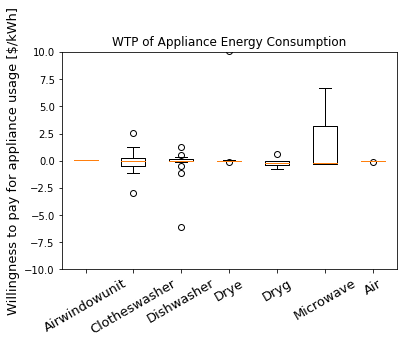

In [108]:
data = [final[0].dropna(),final[1].dropna(),final[2].dropna(),final[4].dropna(),final[5].dropna(),final[7].dropna(),final[16].dropna()]
fig7, ax7 = plt.subplots()
ax7.set_title('WTP of Appliance Energy Consumption')
ax7.boxplot(data)
ax7.set_ylim(-10,10)
ax7.set_ylabel('Willingness to pay for appliance usage [$/kWh]',fontsize=13)
ax7.set_xticklabels(['Airwindowunit', 'Clotheswasher', 'Dishwasher', 'Drye',
       'Dryg', 'Microwave', 'Air'],rotation=30,fontsize=13)
plt.show()

In [102]:
np.array(appliance_list)[[0,1,2,4,5,6,7,16]]

array(['airwindowunit1', 'clotheswasher1', 'dishwasher1', 'drye1',
       'dryg1', 'freezer1', 'microwave1', 'air1'], dtype='<U20')